In [1]:
# Import packages
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn

In [2]:
# Define constants
seq_len = 4
valid_share = 0.4
min_response_val = 20 # (Arbitrary--based on simulated data)
max_response_val = 50 # (Arbitrary--based on simulated data)
torch.manual_seed(9999)
np.random.seed(9998)

In [3]:
# Specify directory/file paths
data_dir = "Data"

sim_data_file = "DIBS_simulated_fmri_var4model.csv"

In [4]:
# Check that CUDA GPUs are available
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f'Number of GPUs available: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i+1}: {torch.cuda.get_device_name(i)}')
else:
    device = torch.device("cpu")
    print("GPU not available--using CPU instead.")

Number of GPUs available: 1
GPU 1: NVIDIA TITAN Xp


In [5]:
# Load data
data = pd.read_csv(os.path.join(data_dir, sim_data_file), header=0)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,29.289019,33.484715,33.357838,30.492201,30.765345,29.409662,32.390454,34.480410,32.245588,32.924852,...,30.595113,31.211688,31.633938,28.603127,30.243806,31.902274,32.177479,28.321272,30.704222,35.838620
1,31.566575,28.703860,32.800320,30.742553,32.973998,32.508277,34.237903,34.686537,32.994585,32.643972,...,31.357649,33.732831,30.026795,30.054632,30.970367,32.371300,34.189654,34.669279,35.580278,32.112060
2,35.104468,31.798851,34.287203,33.647496,33.587711,35.285930,34.176086,32.455849,34.077551,31.370822,...,29.308797,28.215622,32.468534,32.522033,31.793905,30.762018,30.195970,31.770087,33.420589,35.058752
3,30.993886,34.659743,37.344212,36.436306,37.077792,35.270085,36.665054,36.098563,35.792556,30.770861,...,34.052446,35.106103,37.075949,33.642532,32.766403,32.697285,34.024612,29.855947,35.395989,34.153510
4,35.754337,35.861791,35.129110,38.133572,36.410361,37.260194,35.336919,36.024182,32.741023,37.461137,...,34.383754,38.475876,29.174330,33.992502,34.385723,34.743098,32.201603,35.483379,34.552669,35.088259


In [6]:
# Normalize data
data = (data - min_response_val)/(max_response_val - min_response_val)

In [7]:
# Shuffle data and create test dataset
shuffled_idx = np.random.permutation(len(data))
data = data.loc[shuffled_idx].reset_index(drop=True)

train_data = data.loc[0:int(len(data) * (1-valid_share)), ]
train_data.shape

test_idx = [idx for idx in data.index if idx not in train_data.index]
test_data = data.loc[test_idx, ]
print("Train data: ", train_data.shape, "\nTest data: ", test_data.shape)

Train data:  (31, 1000) 
Test data:  (19, 1000)


In [8]:
# Create input and target sequences for training data
train_input_seq = []
train_target_seq = []


for obs in range(len(train_data)):
    obs_data = train_data.iloc[obs]
    for i in range(len(obs_data) - seq_len):
        train_input_seq.append(obs_data[i:i+seq_len].values)
        train_target_seq.append(obs_data[i+seq_len])
        i += 1
print("# train input seqs: ", len(train_input_seq), "\n# train target seqs: ", len(train_target_seq))

# train input seqs:  30876 
# train target seqs:  30876


In [9]:
# Convert sequences to PyTorch tensors
train_input_tensor = torch.from_numpy(np.array(train_input_seq)).float().unsqueeze(-1)
train_input_tensor = train_input_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
train_input_tensor.shape

torch.Size([30876, 4, 1])

In [10]:
train_target_tensor = torch.from_numpy(np.array(train_target_seq)).float().unsqueeze(-1)
train_target_tensor = train_target_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
train_target_tensor.shape

torch.Size([30876, 1])

In [11]:
# Create RNN model class
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

        out, hidden = self.rnn(x, hidden)

        out = self.fc(out[:, -1, :])

        return out, hidden

In [12]:
# Instantiate model
input_size = 1
hidden_size = 64
output_size = 1

model = RNN(input_size, hidden_size, output_size, n_layers=1)
model.to(device)
model

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [14]:
# Train model
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output, hidden = model(train_input_tensor)
    # print(epoch, output.shape, train_target_tensor.shape, train_target_tensor.view(-1).shape)
    # print(epoch, hidden.shape)
    loss = criterion(output, train_target_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/5000], Loss: 0.0054
Epoch [200/5000], Loss: 0.0052
Epoch [300/5000], Loss: 0.0051
Epoch [400/5000], Loss: 0.0051
Epoch [500/5000], Loss: 0.0051
Epoch [600/5000], Loss: 0.0051
Epoch [700/5000], Loss: 0.0051
Epoch [800/5000], Loss: 0.0051
Epoch [900/5000], Loss: 0.0050
Epoch [1000/5000], Loss: 0.0050
Epoch [1100/5000], Loss: 0.0050
Epoch [1200/5000], Loss: 0.0050
Epoch [1300/5000], Loss: 0.0050
Epoch [1400/5000], Loss: 0.0050
Epoch [1500/5000], Loss: 0.0050
Epoch [1600/5000], Loss: 0.0050
Epoch [1700/5000], Loss: 0.0050
Epoch [1800/5000], Loss: 0.0050
Epoch [1900/5000], Loss: 0.0050
Epoch [2000/5000], Loss: 0.0050
Epoch [2100/5000], Loss: 0.0050
Epoch [2200/5000], Loss: 0.0050
Epoch [2300/5000], Loss: 0.0050
Epoch [2400/5000], Loss: 0.0050
Epoch [2500/5000], Loss: 0.0050
Epoch [2600/5000], Loss: 0.0050
Epoch [2700/5000], Loss: 0.0050
Epoch [2800/5000], Loss: 0.0050
Epoch [2900/5000], Loss: 0.0050
Epoch [3000/5000], Loss: 0.0050
Epoch [3100/5000], Loss: 0.0050
Epoch [3200/5000]

In [15]:
# Generate predicted values for training data
model.eval()
with torch.no_grad():
    train_predictions, _ = model(train_input_tensor)
train_predictions

tensor([[0.5214],
        [0.5267],
        [0.5483],
        ...,
        [0.4772],
        [0.4944],
        [0.5086]], device='cuda:0')

In [16]:
# Compute MSE for training data
train_target_tensor = train_target_tensor.cpu()
train_predictions = train_predictions.cpu()

train_mse = (sum((train_target_tensor - train_predictions)**2))/len(train_predictions)
train_mse

tensor([0.0050])

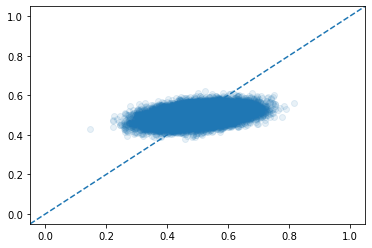

In [17]:
# Plot train predictions against actuals
fig, ax = plt.subplots()
ax.scatter(
    x=train_target_tensor.cpu(),
    y=train_predictions.cpu(),
    alpha=0.1
)
ax.axline([0, 0], [1, 1], linestyle="--")

In [18]:
# Create input and target sequences for test data
test_input_seq = []
test_target_seq = []

for obs in range(len(test_data)):
    obs_data = test_data.iloc[obs]
    for i in range(len(obs_data) - seq_len):
        test_input_seq.append(obs_data[i:i+seq_len].values)
        test_target_seq.append(obs_data[i+seq_len])
        i += 1
print("# test input seqs: ", len(test_input_seq), "\n# test target seqs: ", len(test_target_seq))

# test input seqs:  18924 
# test target seqs:  18924


In [19]:
# Convert test sequences to PyTorch tensors
test_input_tensor = torch.from_numpy(np.array(test_input_seq)).float().unsqueeze(-1)
test_input_tensor = test_input_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
test_input_tensor.shape

torch.Size([18924, 4, 1])

In [20]:
test_target_tensor = torch.from_numpy(np.array(test_target_seq)).float().unsqueeze(-1)
test_target_tensor = test_target_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
test_target_tensor.shape

torch.Size([18924, 1])

In [21]:
# Generate predictions for test data
model.eval()
with torch.no_grad():
    test_predictions, _ = model(test_input_tensor)
test_predictions

tensor([[0.5282],
        [0.5331],
        [0.5330],
        ...,
        [0.4982],
        [0.4798],
        [0.4660]], device='cuda:0')

In [22]:
# Compute MSE for test data
test_target_tensor = test_target_tensor.cpu()
test_predictions = test_predictions.cpu()

test_mse = (sum((test_target_tensor - test_predictions)**2))/len(test_predictions)
test_mse

tensor([0.0054])

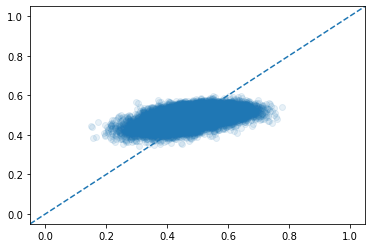

In [23]:
# Plot test predictions against actuals
fig, ax = plt.subplots()
ax.scatter(
    x=test_target_tensor.cpu(),
    y=test_predictions.cpu(),
    alpha=0.1
)
ax.axline([0, 0], [1, 1], linestyle="--")